In [2]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('apw-notebook')
%matplotlib inline
from scipy.interpolate import interp1d

from ebak import SimulatedRVOrbit
from ebak.singleline import RVData, OrbitModel
from ebak.sampler import (design_matrix, sinusoid_model, period_grid, tensor_vector_scalar, 
                          marginal_ln_likelihood, sample_posterior)

## Working in units of [day, km/s], generate some fake data:

In [102]:
np.random.seed(42)
n_data = 9

n_terms = 1
true_p = np.array([-131.2, 3., 0.1])
true_P = 53.1 # days

t = np.full(n_data, 56712.) + np.random.uniform(0, 32, n_data)*true_P
rv = sinusoid_model(true_p, t, true_P)

sigma = np.ones_like(t) * 0.3 # typical uncertainty
rv += np.random.normal(0, sigma)

inv_var = 1 / sigma**2

data = RVData(t, rv*u.km/u.s, ivar=inv_var/(u.km/u.s)**2)

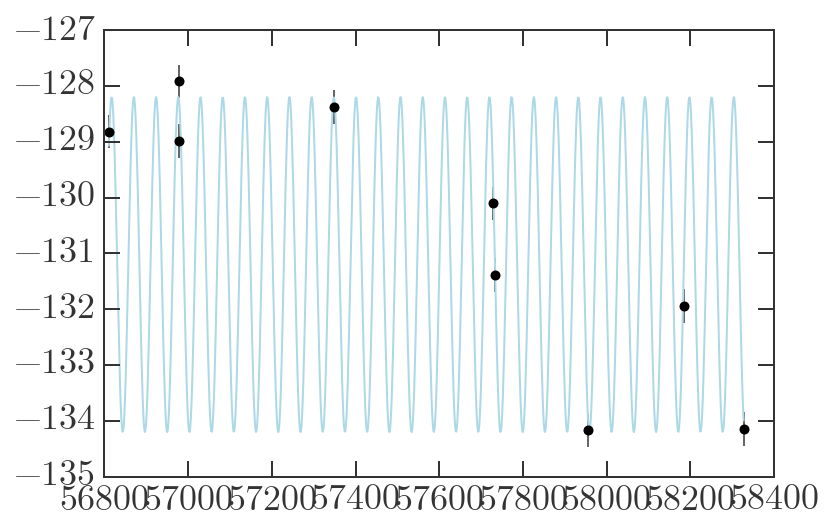

In [103]:
# plot the curve for the true model
_t = np.linspace(t.min(), t.max(), 1024)
plt.plot(_t, sinusoid_model(true_p, _t, true_P), marker=None, color='lightblue')
data.plot(ax=plt.gca())

## Grid in periods

The claim for period spacing: 
$$
dP = \frac{P^2}{2\pi T_{\rm max}}
$$

In [15]:
P_grid, dP_grid = period_grid(data, resolution=2, P_min=10.)

The model: 
$$
\sum_{k=1}^1 \left[a_k \cos\left(\frac{2\pi k t}{P}\right) + b_k \sin\left(\frac{2\pi k t}{P}\right)\right] + v_0
$$

In [16]:
marginal_ln_likelihood(53., data)

21.156042701341239

In [17]:
marg_ln_likes = np.array([marginal_ln_likelihood(P, data) for P in P_grid])

(10.0, 10718.184509358589)

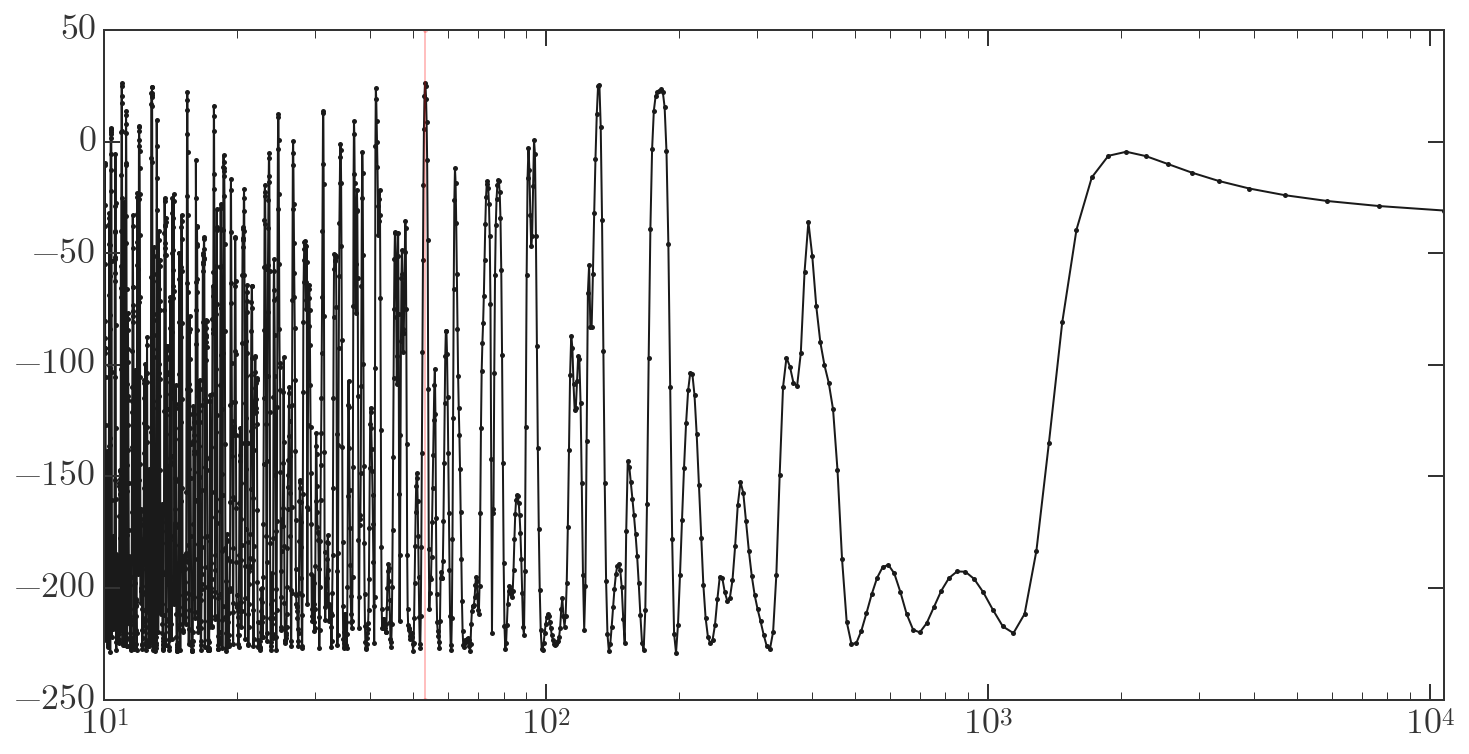

In [18]:
plt.figure(figsize=(12,6))
plt.semilogx(P_grid, marg_ln_likes)
plt.axvline(true_P, color='r', alpha=0.25)
plt.xlim(P_grid.min(), P_grid.max())
# plt.xlim(1.4, 1.45)

In [19]:
# assuming prior on periods flat in ln(P)
probs = np.exp(marg_ln_likes - marg_ln_likes.max()) * dP_grid / P_grid

(1e-09, 1.0)

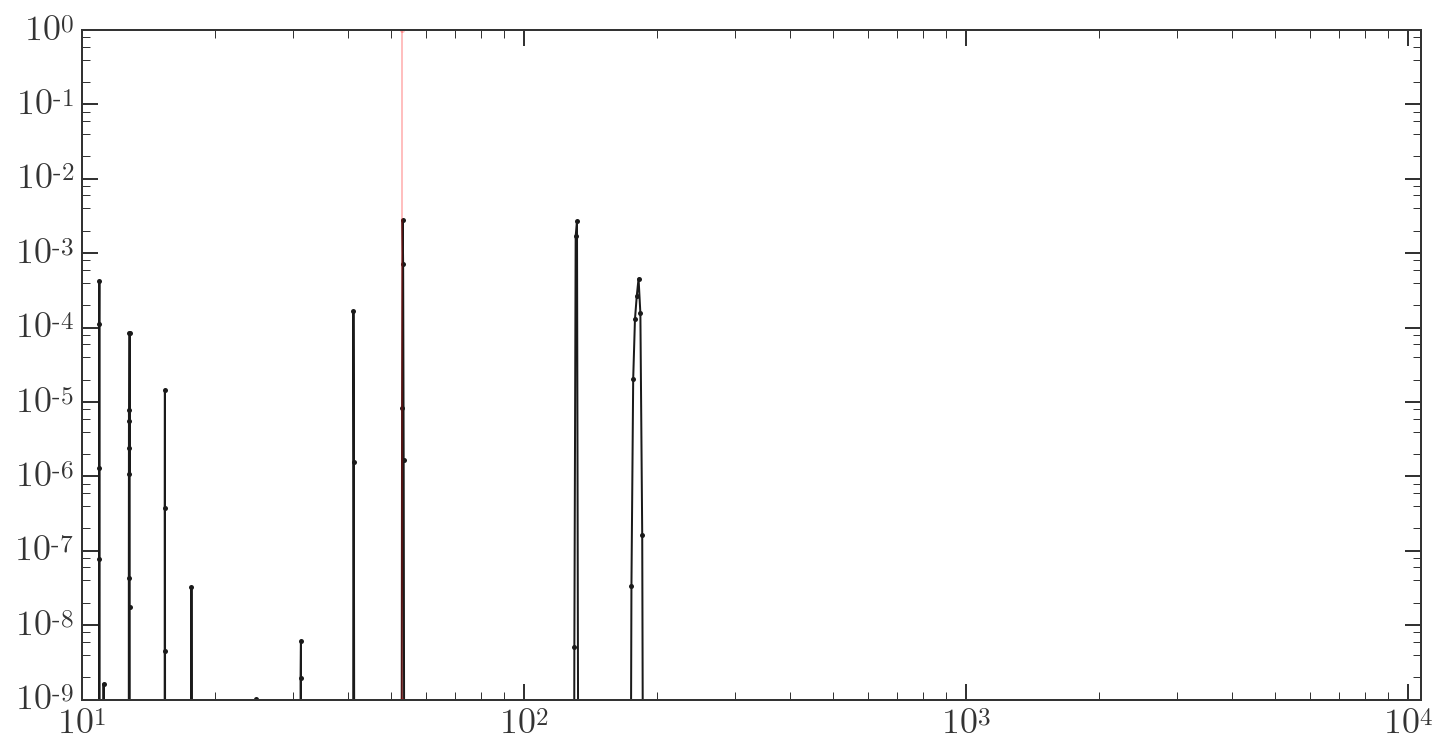

In [20]:
plt.figure(figsize=(12,6))
plt.loglog(P_grid, probs)
plt.axvline(true_P, color='r', alpha=0.25)
plt.xlim(P_grid.min(), P_grid.max())
plt.ylim(1E-9, 1E0)

(10.0, 10718.184509358589)

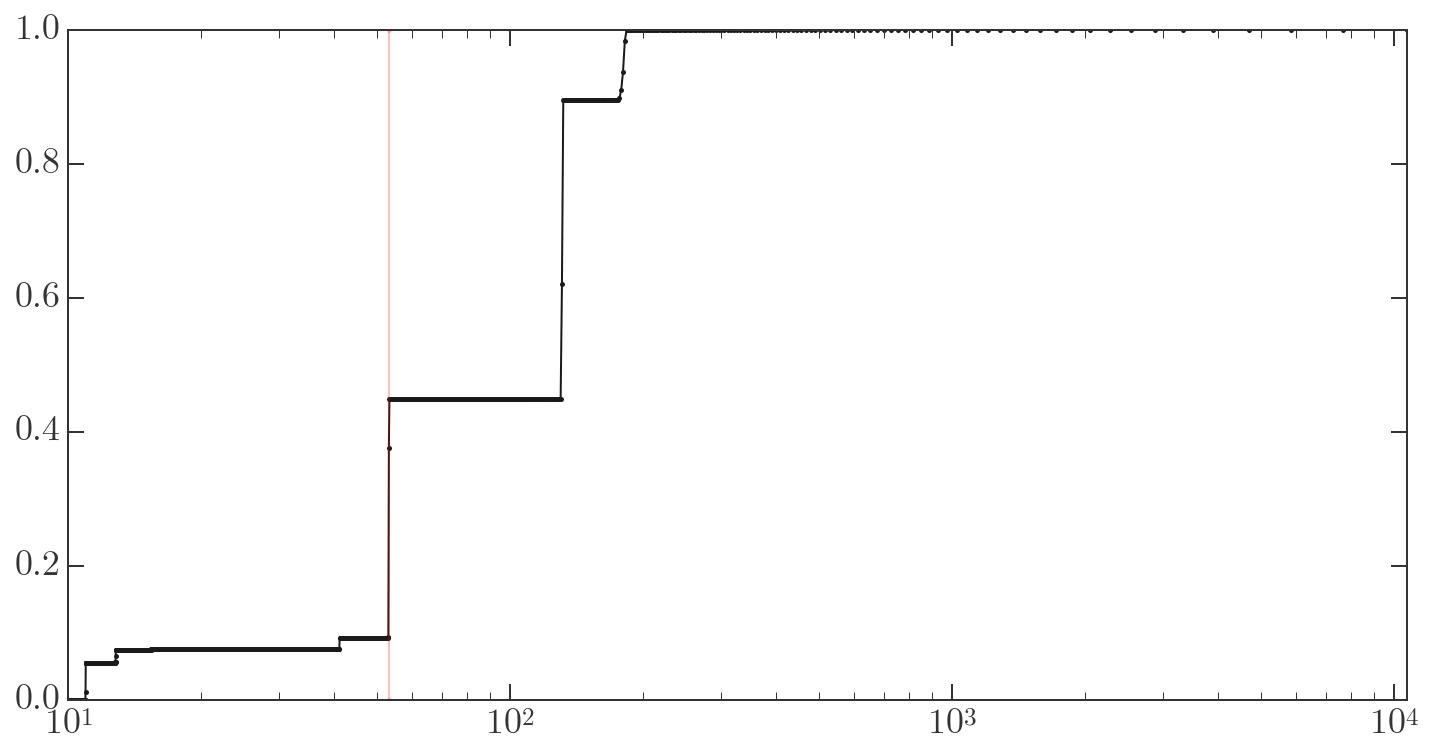

In [21]:
norm_cumsum = np.cumsum(probs) / probs.sum()

plt.figure(figsize=(12,6))
plt.semilogx(P_grid, norm_cumsum)
plt.axvline(true_P, color='r', alpha=0.25)
plt.xlim(P_grid.min(), P_grid.max())

(10.0, 10718.184509358589)

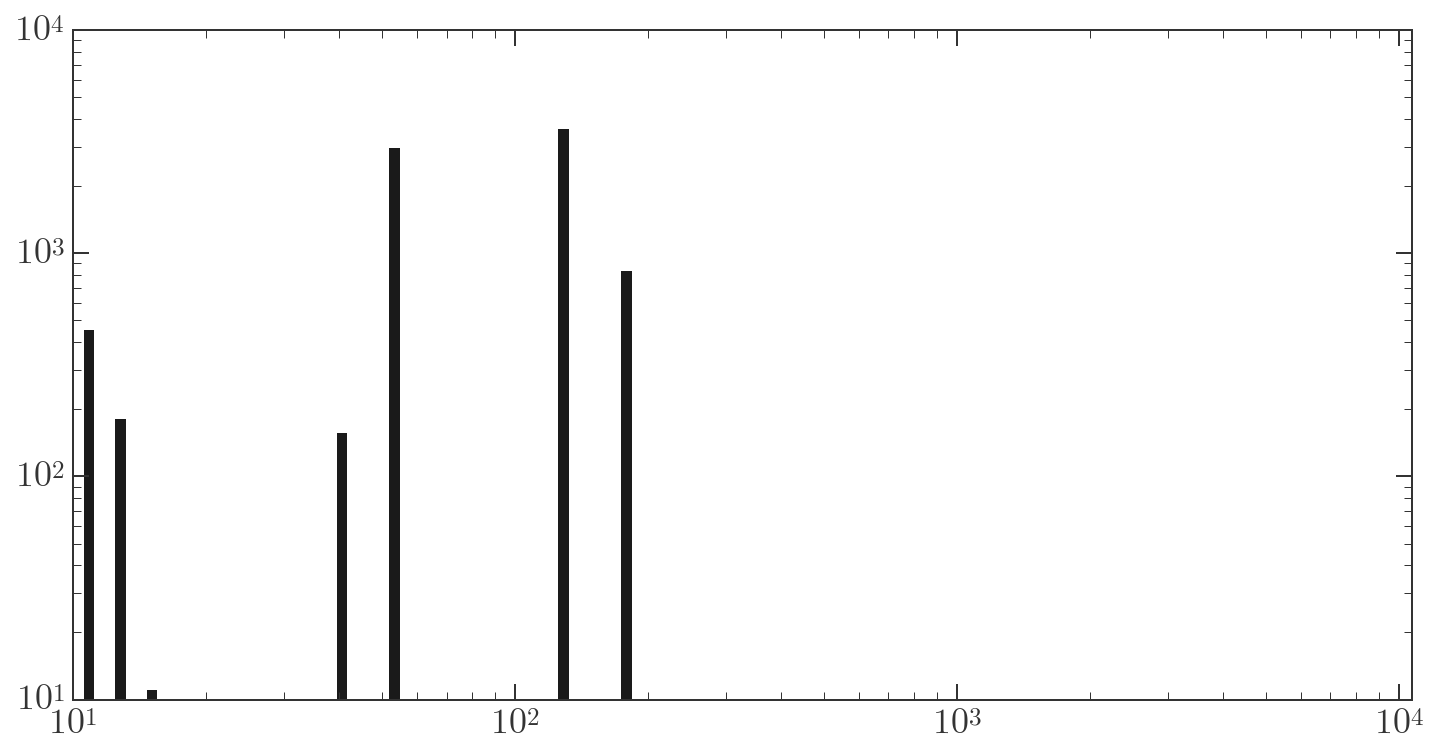

In [22]:
plt.figure(figsize=(12,6))

bins = np.logspace(np.log10(P_grid.min()), np.log10(P_grid.max()), 128)
plt.hist(sample_posterior(P_grid, probs, size=8192), bins=bins);

plt.xscale('log')
plt.yscale('log')
plt.xlim(P_grid.min(), P_grid.max())

In [23]:
def build_the_sampling(Ps, data):
    samples = np.zeros((len(Ps), 4))
    for i,P in enumerate(Ps):
        invvar,mean,_ = tensor_vector_scalar(P, data)
        cov = np.linalg.inv(invvar)
        samples[i,0] = P
        samples[i,1:] = np.random.multivariate_normal(mean, cov)    
    
    return samples

In [24]:
Ps = sample_posterior(P_grid, probs, size=32)
samples = build_the_sampling(Ps, data)

(-136.19999999999999, -126.19999999999999)

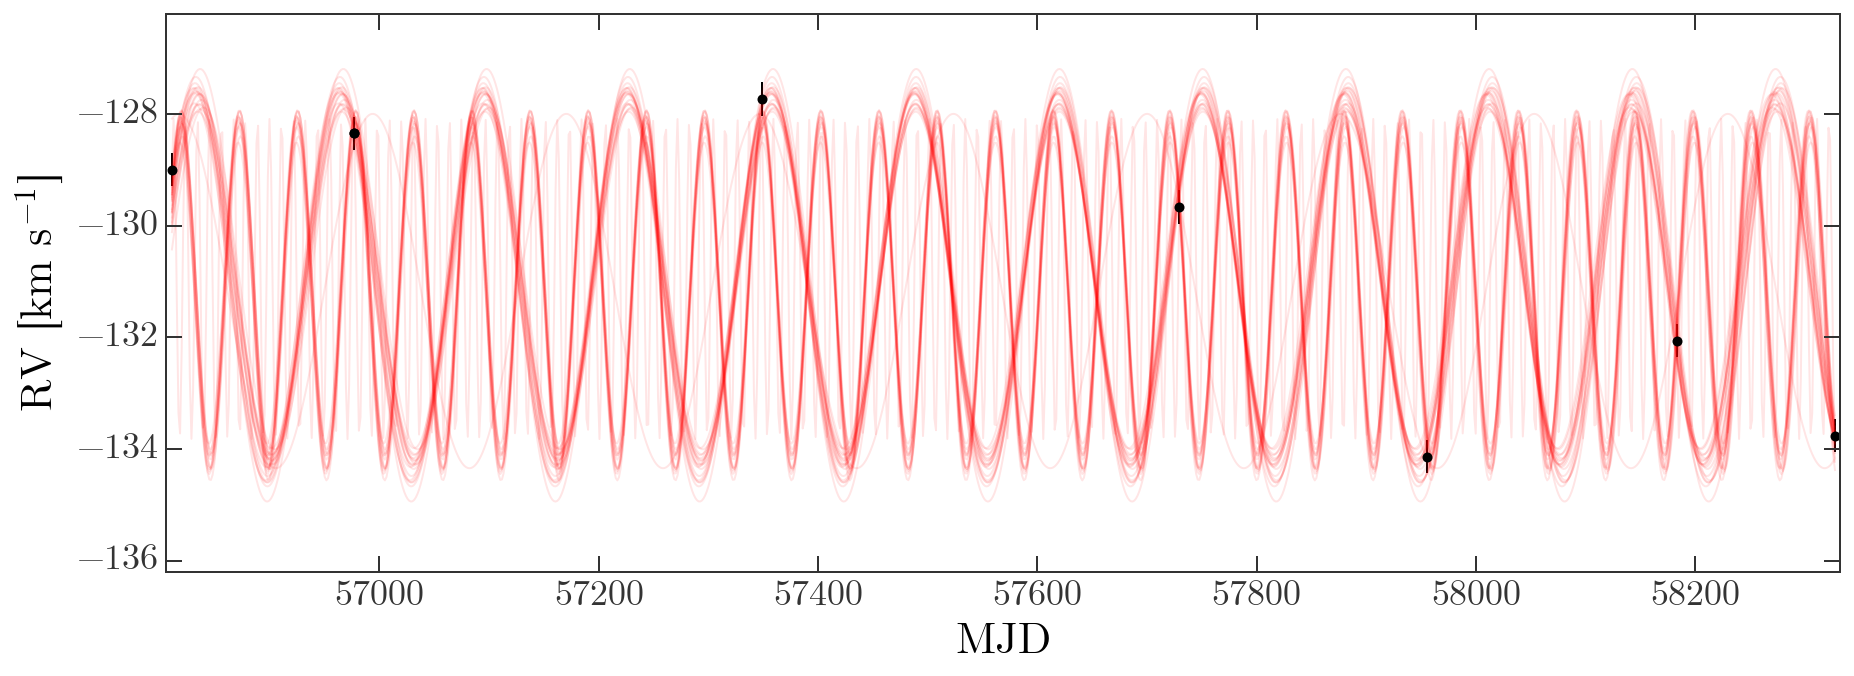

In [26]:
plt.figure(figsize=(15,5))

# plot the curve for the true model
_t = np.linspace(t.min(), t.max(), 1024)

for sample in samples:
    P,*p = sample
    model_rv = (sinusoid_model(p, _t, P)*u.au/u.day).to(u.km/u.s)
    plt.plot(_t, model_rv, marker=None, alpha=0.1, color='r')

plt.errorbar(t, rv, yerr=sigma, marker='o', linestyle='none', color='k')
plt.xlim(t.min()-5, t.max()+5)
plt.xlabel('MJD')
plt.ylabel('RV [km s$^{-1}$]')

plt.ylim(true_p[0]-5, true_p[0]+5)

In [35]:
def orbit_from_sample(sample, ecc, omega):
    P,v0,a1,b1 = sample
    
    Ksini = np.sqrt(a1**2 + b1**2)
    asini = Ksini*P/(2*np.pi) * np.sqrt(1 - ecc**2) # - is this right? might just be K
    phi0 = np.arctan2(b1, a1)
    
    return SimulatedRVOrbit(P*u.day, asini*u.au, ecc=ecc, omega=omega*u.radian, 
                            phi0=phi0*u.radian, v0=-v0*u.au/u.day)

(56810.695673796203, 58327.453749451728)

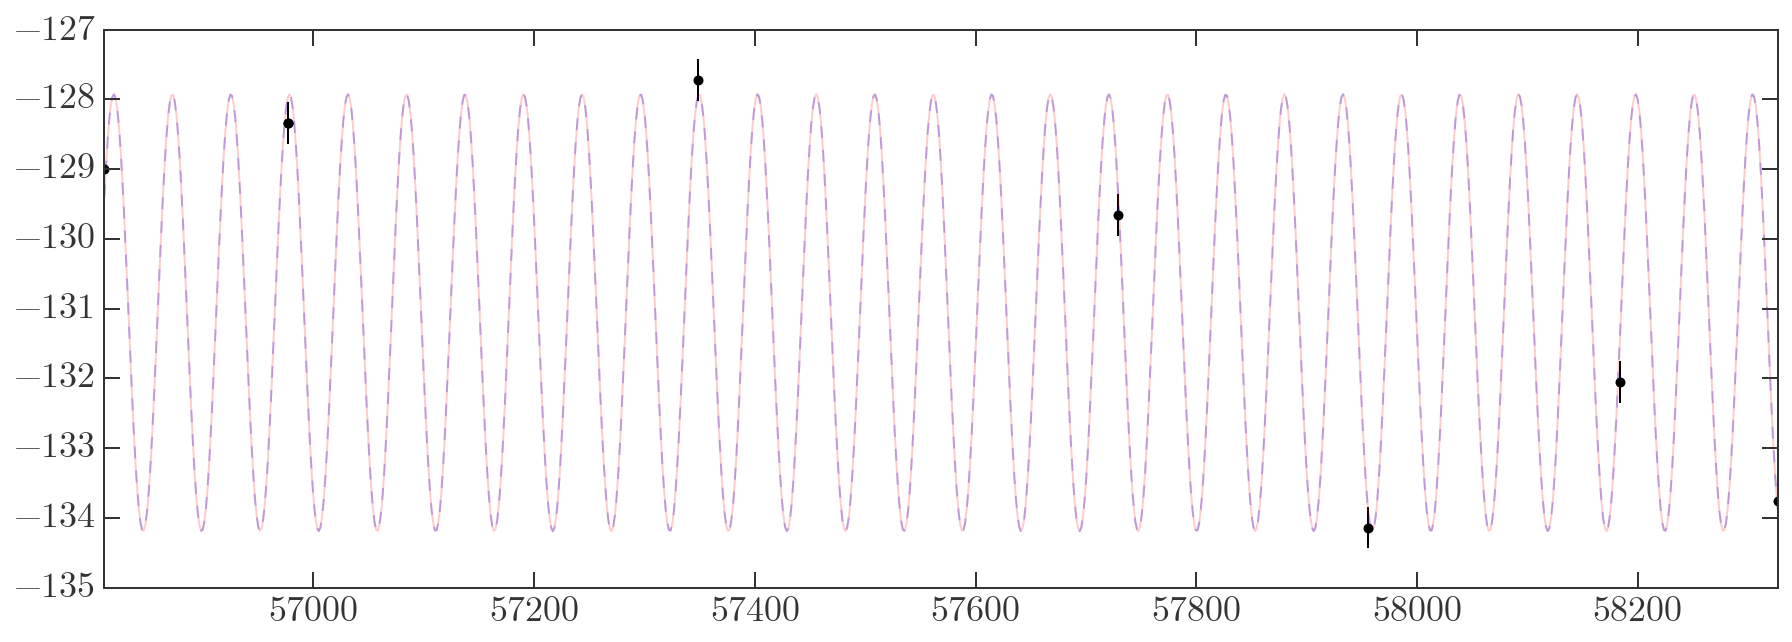

In [23]:
plt.figure(figsize=(15,5))

# plot the curve for the true model
_t = np.linspace(t.min(), t.max(), 1024)

for idx in range(1):
    sample = samples[idx]
    P,*p = sample
    model_rv = (sinusoid_model(p, _t, P)*u.au/u.day).to(u.km/u.s)
    plt.plot(_t, model_rv, marker=None, alpha=0.2, color='r')
    
    # ecc = np.random.beta(a=0.867, b=3.03) # MAGIC NUMBERS: Kipping
    # omega = np.random.uniform(0, 2*np.pi)
    orbit = orbit_from_sample(sample, 0., 0.)
    
    plt.plot(_t, orbit.generate_rv_curve(_t), linestyle='--', marker=None, alpha=0.25, color='b')

plt.errorbar(t, rv, yerr=sigma, marker='o', linestyle='none', color='k')
plt.xlim(t.min(), t.max())

---

## SMC

In [104]:
import corner
from ebak import EPOCH
from ebak.util import find_t0
from ebak.celestialmechanics import rv_from_elements

In [140]:
n_samples = 2**20
P_min = 8. # day
# P_max = 1E4 # day
P_max = 256. # day
n_samples

1048576

In [141]:
P = np.exp(np.random.uniform(np.log(P_min), np.log(P_max), size=n_samples))
phi0 = np.random.uniform(0, 2*np.pi, size=n_samples)
ecc = np.random.beta(a=0.867, b=3.03, size=n_samples) # MAGIC NUMBERS: Kipping
omega = np.random.uniform(0, 2*np.pi, size=n_samples)

# ecc *= 0 # HACK

In [142]:
nl_p = np.vstack((P, phi0, ecc, omega)).T
# linear parameters are: v0, asini

/Users/adrian/anaconda/envs/ebak/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/adrian/anaconda/envs/ebak/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


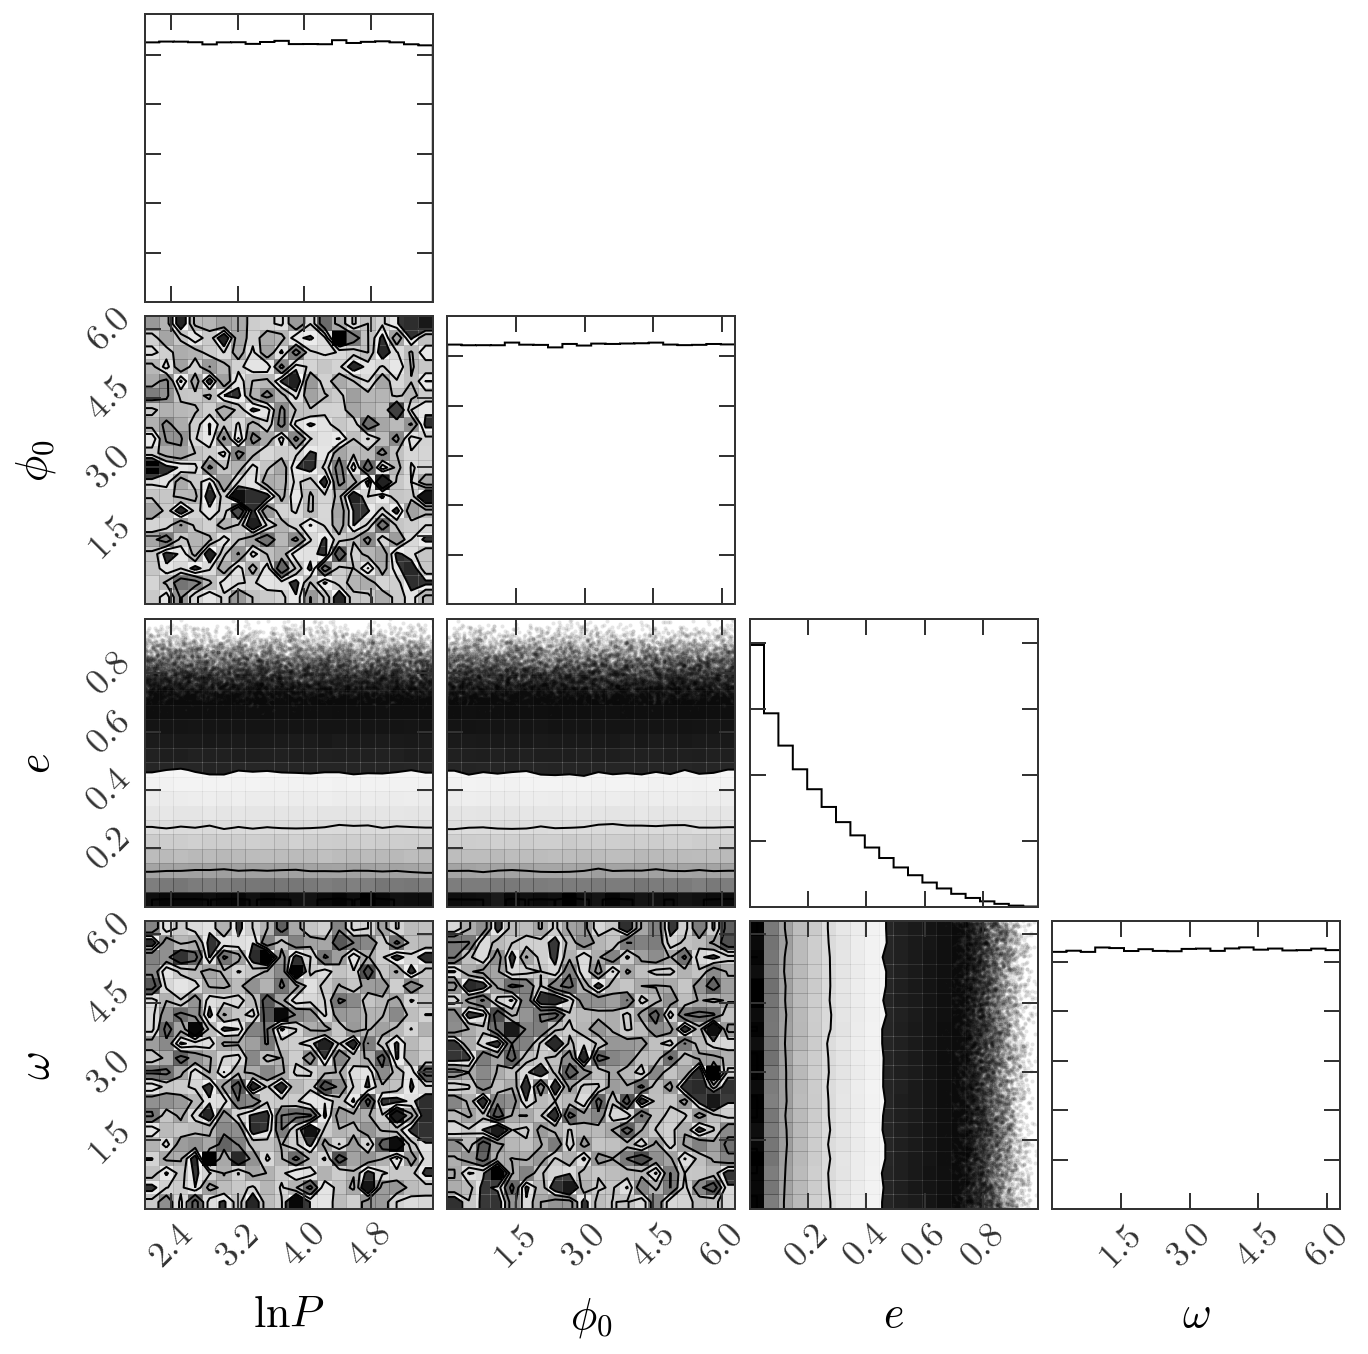

In [143]:
fig = corner.corner(np.hstack((np.log(nl_p[:,0:1]), nl_p[:,1:])), 
                    labels=['$\ln P$', r'$\phi_0$', '$e$', r'$\omega$'])

In [144]:
def design_matrix_kepler(t, nl_p):
    t = np.atleast_1d(t)
    P, phi0, ecc, omega = nl_p
    
    a = np.ones_like(t)
    x1 = rv_from_elements(t, P, 1., ecc, omega, phi0, 0.)
    X = np.vstack((a, x1)).T
    return X

In [145]:
def tensor_vector_scalar_kepler(nl_p, data):
    """
    
    """
    A = design_matrix_kepler(data._t, nl_p)
    ATCinv = (A.T * data._ivar[None])
    ATA = ATCinv.dot(A)

    # Note: this is unstable!
    p = np.linalg.solve(ATA, ATCinv.dot(data._rv))
    # if cond num is high, do:
    # p,*_ = np.linalg.lstsq(A, y)
    
    dy = A.dot(p) - data._rv
    chi2 = np.sum(dy**2 * data._ivar)

    return ATA, p, chi2

In [146]:
def marginal_ln_likelihood(ATA, chi2):
    sign,logdet = np.linalg.slogdet(ATA)
    assert np.all(sign == 1.)

    return -0.5*chi2 + 0.5*logdet

In [147]:
Ts = np.zeros((n_samples, 2, 2))
Vs = np.zeros((n_samples, 2))
Ss = np.zeros(n_samples)

for i in range(n_samples):
    Ts[i],Vs[i],Ss[i] = tensor_vector_scalar_kepler(nl_p[i], data)

/Users/adrian/anaconda/envs/ebak/lib/python3.5/site-packages/ebak-0.1.dev0-py3.5.egg/ebak/celestialmechanics.py:101: RuntimeWarning: eccentric_anomaly_from_mean_anomaly() reached maximum number of iterations (128)


In [148]:
marg_ll = marginal_ln_likelihood(Ts, Ss)

In [149]:
fucky = np.random.uniform(size=n_samples) < np.exp(marg_ll - np.max(marg_ll))

In [150]:
fucky.sum()

15

53.3513323636
53.3068230083
53.1894216195
53.2935677906
53.1045555195
53.2251778063
53.2757555428
53.1479061295
53.2768229071
53.2840128119
53.1379384435
179.421883238
53.25015047
53.2245425957
179.44144242


(56810.695673796203, 58327.453749451728)

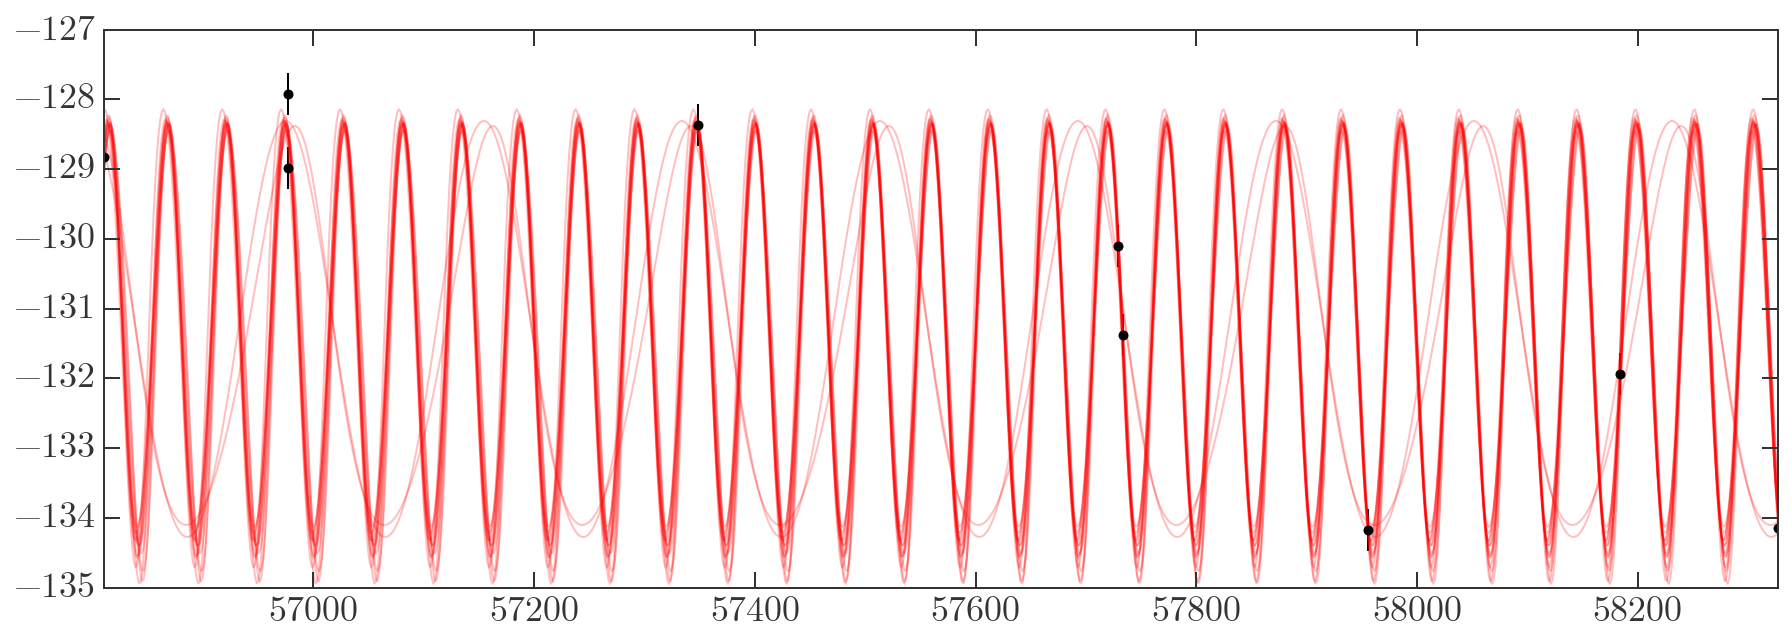

In [151]:
plt.figure(figsize=(15,5))

# plot the curve for the true model
_t = np.linspace(t.min(), t.max(), 1024)

for idx in np.where(fucky)[0]:
    v0,asini = Vs[idx]    
    P, phi0, ecc, omega = nl_p[idx]
    print(P)
#     t0 = find_t0(phi0, P, EPOCH)
    
    model_rv = (rv_from_elements(_t, P, asini, ecc, omega, phi0, -v0)*u.au/u.day).to(u.km/u.s)
    plt.plot(_t, model_rv, linestyle='-', marker=None, alpha=0.25, color='r')

plt.errorbar(t, rv, yerr=sigma, marker='o', linestyle='none', color='k')
plt.xlim(t.min(), t.max())

/Users/adrian/anaconda/envs/ebak/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/adrian/anaconda/envs/ebak/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


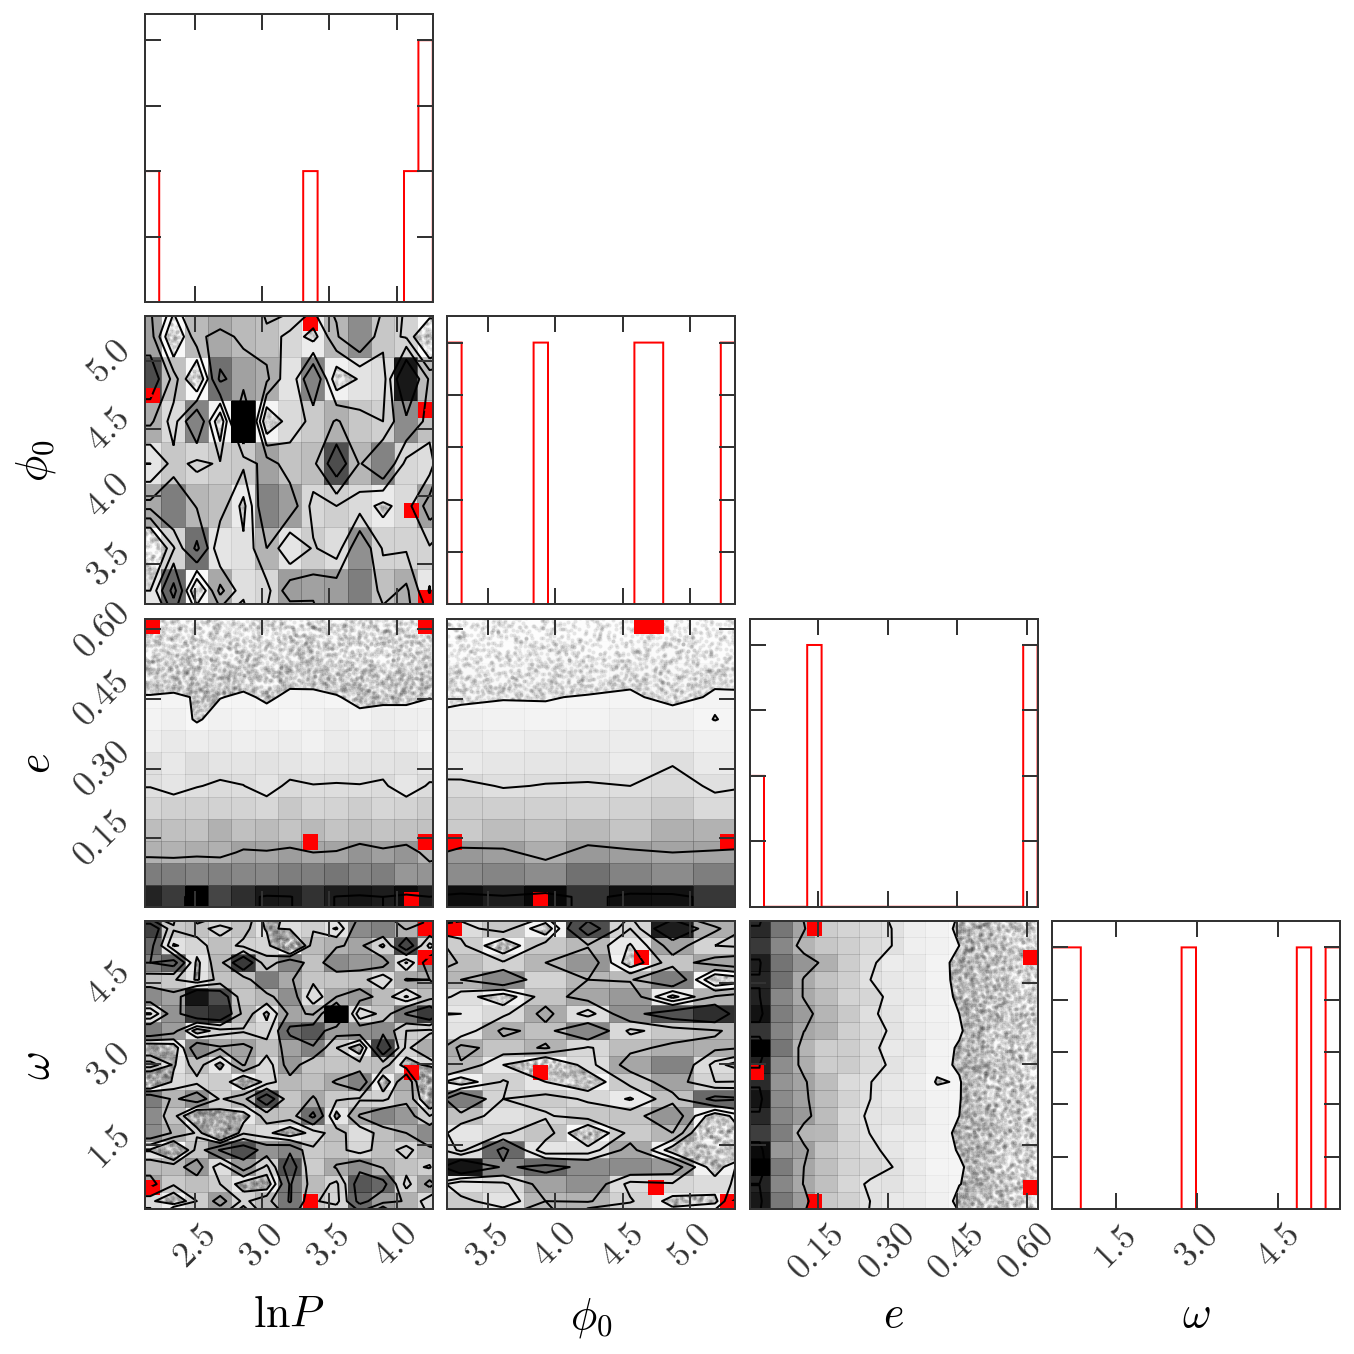

In [157]:
fig = corner.corner(np.hstack((np.log(nl_p[:,0:1]), nl_p[:,1:]))[:65536], 
                    labels=['$\ln P$', r'$\phi_0$', '$e$', r'$\omega$'])

fig = corner.corner(np.hstack((np.log(nl_p[:,0:1]), nl_p[:,1:]))[:5], fig=fig, 
                    color='r', zorder=1000) 